In [ ]:
from zipfile import ZipFile

import re

import random

import seaborn as sns

import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

!pip install pymorphy2
import pymorphy2
morph = pymorphy2.MorphAnalyzer()

from gensim import corpora
from gensim import similarities
from gensim.models import *
from gensim.models import LsiModel
from gensim.models.coherencemodel import CoherenceModel

import matplotlib.pyplot as plt
from matplotlib import style

import numpy as np

import pandas as pd

from sklearn.metrics import *
from sklearn.pipeline import *
from sklearn.feature_extraction.text import *
from sklearn.decomposition import TruncatedSVD, PCA
from sklearn.preprocessing import Normalizer, LabelEncoder

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 55 kB 2.2 MB/s 
     |████████████████████████████████| 8.2 MB 8.5 MB/s 
  Created wheel for docopt: filename=docopt-0.6.2-py2.py3-none-any.whl size=13723 sha256=596494df69170f726710f2c95be0da6fea09a9ef2dd1c96ddf47a1b9a67d2048
  Stored in directory: /root/.cache/pip/wheels/72/b0/3f/1d95f96ff986c7dfffe46ce2be4062f38ebd04b506c77c81b9
Successfully built docopt


In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
#Загрузка всех файлов из zip-архива
def load_data(zip_name):
    documents_list = []
    with ZipFile(zip_name, 'r') as zip:
        zip.extractall()
        listofiles = zip.namelist()
    for element in listofiles:
        text = open(element, 'r', encoding = 'utf-8').read()
        documents_list.append([text])
    print("Всего текстов: ", len(documents_list))
    return documents_list

In [ ]:
#Предобработка текста
def preprocess_data(documents_list):
    #Стоп-слова
    stop_words = stopwords.words("russian")
    #Пунктуация
    punct = re.compile("[^\w\s]")
    processed_documents = []
    for doc in documents_list:
      for text in doc:
        #Избавляемся от пунктуации
        file_without_punct = re.sub(punct, "", text)
        #Приводим к нижнему регистру
        file_without_punct = file_without_punct.lower()
        #Токенизируем
        info_tokenized = word_tokenize(file_without_punct)
        #Лемматизируем
        info_lemmatized = []
        for token in info_tokenized:
            lemma = morph.parse(token)[0]
            lemma = lemma.normal_form
            info_lemmatized.append(lemma)
        #Фильтруем от стоп-слов
        info_filtered = []
        for lemma in info_lemmatized:
            if lemma not in stop_words:
                info_filtered.append(lemma)
        processed_documents.append(info_filtered)
    return processed_documents

In [ ]:
#Проводим предобработку
nltk.download('stopwords')
nltk.download('punkt')
document_list = load_data("LingCorpus.zip")
processed_documents = preprocess_data(document_list)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Всего текстов:  30


In [ ]:
#Создаём словарь, содержащий количество раз, которое слово появляется в обучающем наборе.
dictionary = corpora.Dictionary(processed_documents)
print('Original: {}'.format(dictionary))
#Берём только те слова, которые встречаются минимум в 2 документах и более, чем в 0.9 всех документов.
dictionary.filter_extremes(no_below = 1, no_above = 0.9, keep_n=None)
print('Filtered: {}'.format(dictionary))

corpus = [dictionary.doc2bow(text) for text in processed_documents]

Original: Dictionary(5538 unique tokens: ['10', '1938', '1960ха', '19701980', '1972']...)
Filtered: Dictionary(5537 unique tokens: ['10', '1938', '1960ха', '19701980', '1972']...)


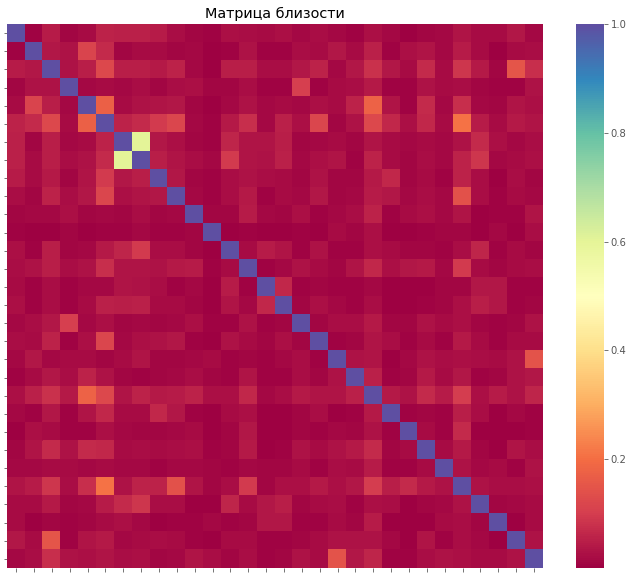

In [ ]:
#Определим семантическую близость документов
style.use('ggplot')

# tf-idf векторах
tfidf = TfidfModel(corpus)
corpus_tfidf = tfidf[corpus]

# вычисление сходства по косинусной мере на tf-idf векторах
index = similarities.MatrixSimilarity(corpus_tfidf)
sims = index[corpus_tfidf]

plt.figure(figsize = (12,10))
sns.heatmap(data=sims, cmap = 'Spectral').set(xticklabels=[], yticklabels=[])
plt.title("Матрица близости")
plt.show()

In [ ]:
#Модель ЛСА - Латентный Семантический анализ
lsi = lsimodel.LsiModel(corpus, id2word=dictionary, num_topics=20, chunksize=50)

In [ ]:
#Можно посмотреть слова, принадлежащие выделенным темам.
lsi.show_topics(num_words=10, formatted=False)

[(0,
  [('слово', 0.7194789041648588),
   ('это', 0.21623404983913985),
   ('имя', 0.19943136427494051),
   ('например', 0.16417768260111412),
   ('русский', 0.1536861096999847),
   ('который', 0.15215941063656924),
   ('значение', 0.13267908644676954),
   ('также', 0.09332043123872634),
   ('ударение', 0.08429069696781204),
   ('признак', 0.08427786666858751)]),
 (1,
  [('имя', 0.7968413366581376),
   ('слово', -0.30626509745860914),
   ('прозвище', 0.1400065123190262),
   ('именование', 0.11756404540881728),
   ('фамилия', 0.11716187049386326),
   ('человек', 0.10505237690036895),
   ('церковный', 0.08703107522534055),
   ('форма', 0.08421628220087765),
   ('русский', 0.0806185713177039),
   ('семья', 0.07552558640289904)]),
 (2,
  [('китайский', -0.31066995034322364),
   ('слово', 0.28801880502481786),
   ('который', -0.22670770224611234),
   ('семиотика', -0.22174181333275414),
   ('тон', -0.19911573042436528),
   ('диалект', -0.18937241683363634),
   ('система', -0.189356629645741

In [ ]:
#Обучаем модель LDA
%time lda = ldamodel.LdaModel(corpus, id2word=dictionary, num_topics=20, chunksize=50, update_every=1, passes=2)

CPU times: user 507 ms, sys: 375 ms, total: 882 ms
Wall time: 481 ms


In [ ]:
lda.show_topics(num_topics=5, num_words=10, formatted=False)

[(6,
  [('слово', 0.016074078),
   ('малаялам', 0.008958084),
   ('это', 0.006692449),
   ('который', 0.0063380687),
   ('семиотика', 0.0062335525),
   ('русский', 0.004368394),
   ('например', 0.003905345),
   ('также', 0.0038815339),
   ('текст', 0.0036310696),
   ('первый', 0.003483996)]),
 (0,
  [('слово', 0.027572088),
   ('это', 0.009457986),
   ('который', 0.009169251),
   ('слог', 0.008004594),
   ('русский', 0.0062282686),
   ('иметь', 0.0055281958),
   ('например', 0.0053744586),
   ('имя', 0.0053471685),
   ('мочь', 0.0051128687),
   ('также', 0.004625646)]),
 (8,
  [('слово', 0.013407048),
   ('типология', 0.012553982),
   ('который', 0.010979886),
   ('глагол', 0.008943206),
   ('например', 0.008192492),
   ('конструкция', 0.007882005),
   ('грамматический', 0.007048289),
   ('подлежащее', 0.0065910486),
   ('морфологический', 0.005834121),
   ('это', 0.0056171454)]),
 (15,
  [('семиотика', 0.013749771),
   ('имя', 0.00854482),
   ('который', 0.0065371874),
   ('семиотичес

In [ ]:
#Визуализация LDA
!pip install pyLDAvis
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
#import pyLDAvis.gensim as gensimvis

%time vis_data = gensimvis.prepare(lda, corpus, dictionary)
pyLDAvis.display(vis_data)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.7 MB 5.2 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
    Preparing wheel metadata ... done
  Created wheel for pyLDAvis: filename=pyLDAvis-3.3.1-py2.py3-none-any.whl size=136898 sha256=3aa11fc60849859edb2152208511a0db95c8f609521c1ac02a06635b9ff34b93
  Stored in directory: /root/.cache/pip/wheels/c9/21/f6/17bcf2667e8a68532ba2fbf6d5c72fdf4c7f7d9abfa4852d2f
  Created wheel for sklearn: filename=sklearn-0.0.post1-py3-none-any.whl size=2344 sha256=f78df32f1520551f3df4e813e4def428c6eb4775a78815834f9d35fbcaa7c8a0
  Stored in directory: /root/.cache/pip/wheels/42/56/cc/4a8bf86613aafd5b7f1b310477667c1fca5c51c3ae4124a003
Successfully built pyLDAvis sklearn


/usr/local/lib/python3.7/dist-packages/past/types/oldstr.py:5: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Iterable


CPU times: user 641 ms, sys: 205 ms, total: 846 ms
Wall time: 3.36 s
